## Graph DB 연결하기

Crime Investigation Dataset: https://github.com/neo4j-graph-examples/pole

In [ ]:
from neo4j import GraphDatabase

URI = "neo4j+s://your-database-uri"
AUTH = ("your-username", "your-password")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [ ]:
driver = GraphDatabase.driver(URI, auth=AUTH)

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM

llm = OpenAILLM(model_name="gpt-4o")

## Graph 기반 RAG 구현하기 : Text2Cypher

### 1. POLE 그래프 이해하기

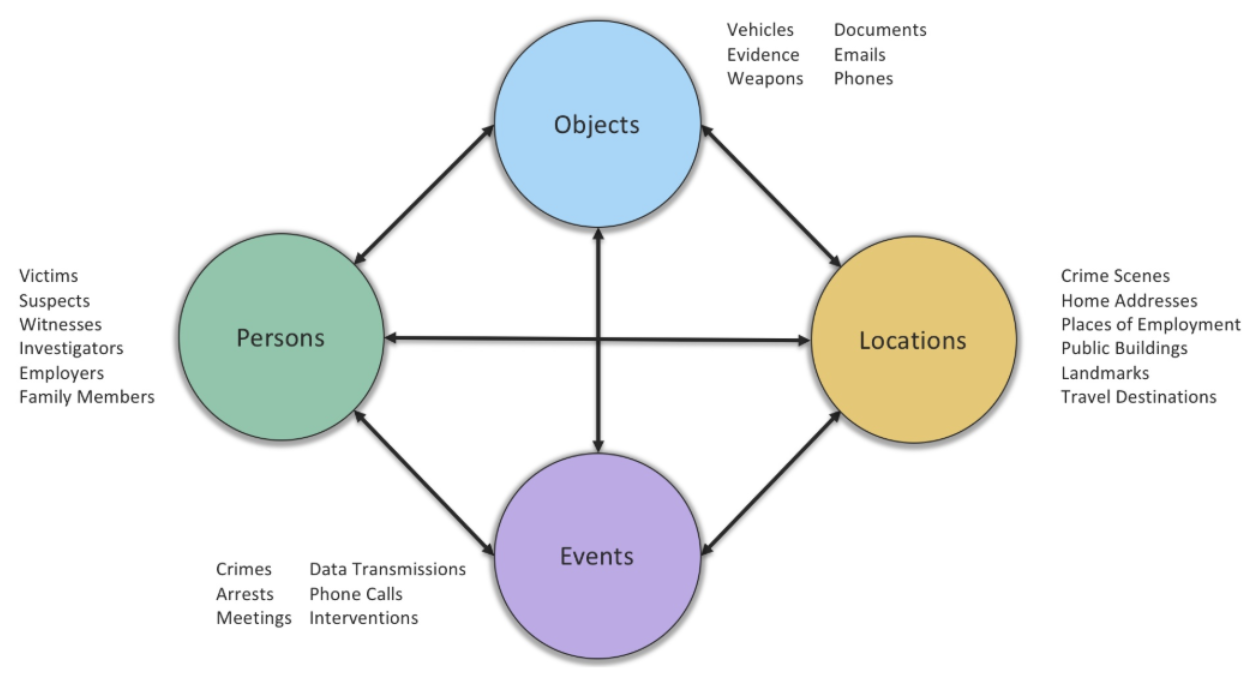
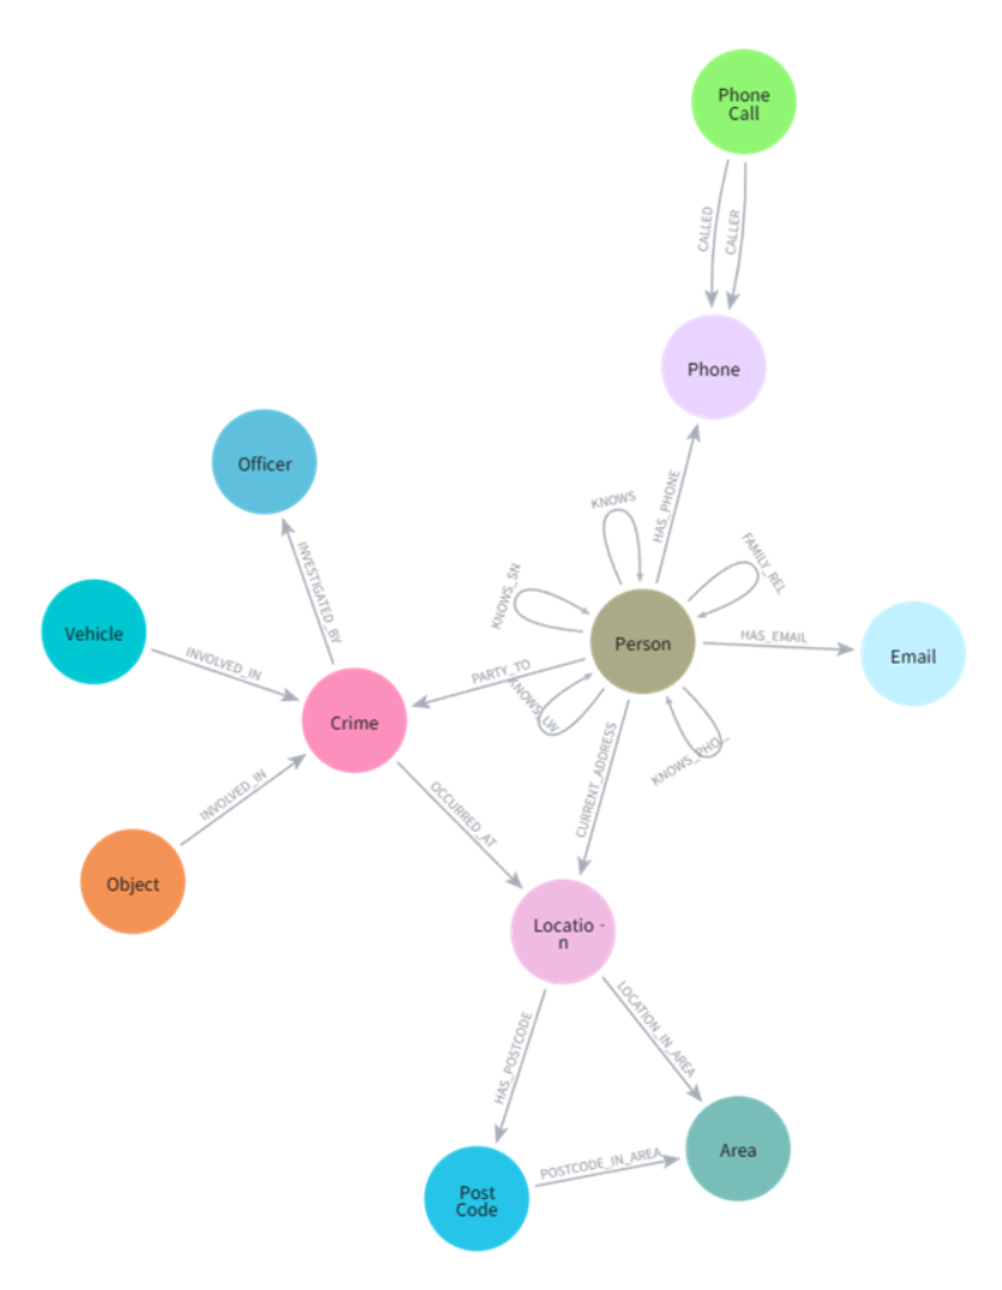


#### Text2Cypher Examples:

USER INPUT : Piccadilly 에서 발생한 범죄 건수는?
// Crime 노드와 occured_at 관계를 가진 location 중 address가 piccadilly인 범죄 횟수
QUERY : MATCH (c:Crime)-[:OCCURRED_AT]->(l:Location {address: 'Piccadilly'})
RETURN count(c) AS crime_count

USER INPUT : M22 8ER 우편번호 지역의 범죄 유형 분포는?
QUERY: MATCH (pc:PostCode {code: "M22 8ER"})<-[:HAS_POSTCODE]-(l:Locaton)<-[:OCCURRED_AT]-(c:Crime)
RETURN c.type, count(*) AS count
ORDER BY count DESC

USER INPUT: 주로 어느 지역에서 차량 범죄가 많이 발생하나요?
QUERY: MATCH (v:Vehicle)-[:INVOLVED_IN]->(c:CRIME)-[:OCCURRED_AT]->(l:Location)
RETURN 1.address AS location, count(c) AS vehicle_crime_count
ORDER BY vehicle_crime_count DESC
LIMIT 5

USER INPUT : 어느 주소(또는 지역/우편번호)에서 범죄가 가장 많이 발생했나요?
QUERY: MATCH (1:Location)<-[:OCCURED_AT]-(:Crime)
RETURN 1.address AS address, 1.postcode AS postcode, count(1) AS total
ORDER BY count(1) DESC
LIMIT 15

USER INPUT: Larive 경관(badge no 26-5234182)이 수사 중인 사건은 무엇인가요?
QUERY: MATCH (c:Crime {last_outcome: 'Under investigation'})-[i:INVESTIGATED_BY]->(o:Officer {badge_no: '26-52344182', surname: 'Larive'})
return *

USER INPUT: 범죄 관련자는 아니지만, 위험한 지인을 가장 많이 알고 있는 사람을 알려주세요.
QUERY: MATCH (p:Person)-[:KNOWS]-(friend)-[:PARTY__TO]->(:Crime)
WHERE NOT (p:Person)-[:PARTY_TO]->(:Crime)
RETURN p.name AS name, p.surname AS surname, p.nhs_no AS id, count(distinct friend) AS dangerousFriends
ORDER BY dangerousFriends DESC
LIMIT 5

### Text2Cypher Retriever 사용하기

https://neo4j.com/docs/neo4j-graphrag-python/current/api.html#text2cypherretriever

### DB 스키마 작성하기
- 첫번째 방법 : 노드, 관계 프로퍼티, 관계방향성

DB 스키마 예시:

Node Properties:
Person {name: STRING, born: INTEGER}
Movie {tagline: STRING, title: STRING, released: INTEGER}
Relationship properties:
ACTED_IN {roles: LIST}
REVIEWED {summary: STRING, rating: INTEGER}
The relationships:
(:Person)-[:ACTED_IN]->(:Movie)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:PRODUCED]->(:Movie)
(:Person)-[:WROTE]->(:Movie)
(:Person)-[:FOLLOWS]->(:Person)
(:Person)-[:REVIEWED]->(:Movie)

In [ ]:
# 위 스키마 형태 추출

from collections import defaultdict

def get_schema():
    schema = ""
    with driver.session() as session:
        # 모든 노드 라벨과 속성 추출
        node_schema = session.run("""
        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes
        RETURN nodeType, propertyName, propertyTypes
        """)

        nodes = defaultdict(list)
        for record in node_schema:
            label = record["nodeType"].replace(":", "")
            prop = record["propertyName"]
            types = record["propertyTypes"]
            nodes[label][prop] = types[0] if types else "UNKOWN"

        # 모든 관계 타입과 속성 추출
        rel_schema = session.run("""
        CALL db.schema.relTypeProperties() YIELD relType, propertyName, propertyTypes
        RETURN relType, propertyName, propertyTypes
        """)

        relationships = defaultdict(dict)
        for record in rel_schema:
            rel = record["relType"]
            prop = record["propertyName"]
            types = record["propertyTypes"]
            relationships[rel][prop] = types[0] if types else "UNKOWN"

        # 관계 방향 및 타입 추출
        rel_types = session.run("""
        MATCH (a)-[r]->(b)
        RETURN DISTINCT type(r) AS rel_type, labels(a) AS from_labels, labels(b) AS to_labels
        """)

        rel_directions = set()
        for record in rel_types:
            from_labels = f":{record['from_labels'][0]}"
            to_labels = f":{record['to_labels'][0]}"
            rel_type = record["rel_type"]
            rel_directions.add((f"{from_labels}-[:{rel_type}]->{to_labels}"))

        # 출력
        schema += "\nNode properties:\n"
        for label, props in nodes.items():
            prop_str = ". ".join([f"{k}: {v}" for k, v in props.items()])
            schema += f"{label} {{{prop_str}}}\n"

        schema += "\nRelationship properties:\n"
        for rel, props in relationships.items():
            prop_str = ". ".join([f"{k}: {v}" for k, v in props.items()])
            schema += f"{rel} {{{prop_str}}}\n"

        schema += "\nThe Relationships:\n"
        for rel in sorted(rel_directions):
            schema += f"{rel}\n"
        return schema
    
schema = get_schema()

In [ ]:
print(schema)

- 두번째 방법 : JSON

descripthon을 달아주어 llm에게 더 많은 정보를 줄 수 있음

In [ ]:
from collections import defaultdict

def extract_schema_json():
    with driver.session() as session:
        # 노드 정보 추출
        node_data = session.run("""
        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes
        RETURN nodeType, propertyName, propertyTypes
        """)

        entities = defaultdict(list)
        for record in node_data:
            label = record["nodeType"].replace(":", "")
            property_name = record["propertyName"]
            property_type = record["propertyTypes"][0] if record["propertyTypes"] else "UNKNOWN"
            entities[label].append({
                "name": property_name,
                "type": property_type,
                "description": ""  # ← 수동 설명 입력 가능
            })

        # 관계 정보 추출
        rel_data = session.run("""
        CALL db.relationshipTypes() YIELD relationshipType
        RETURN relationshipType
        """)

        relations = []
        for record in rel_data:
            rel_type = record["relationshipType"]
            relations.append({
                "label": rel_type,
                "description": ""  # ← 수동 설명 입력 가능
            })

        # 결과 구성
        schema_json = {
            "entities": [
                {
                    "label": label,
                    "description": "",  # ← 수동 설명 입력 가능
                    "properties": props
                }
                for label, props in entities.items()
            ],
            "relations": relations
        }

        return schema_json
    
# 출력
import json
schema = extract_schema_json()
print(json.dumps(schema, indent=4))

Text2Cypher Retriever로 검색하기

In [ ]:
from neo4j import GraphDatabase
from neo4j_graphrag.retrievers import Text2CypherRetriever
from neo4j_graphrag.llm import OpenAILLM

neo4j_schema = get_schema() # get_schema() str(extract_schema_json())

examples = [
    """
    USER INPUT: Piccadilly에서 발생한 범죄 건수는?
    QUERY: MATCH (c:Crime)-[:OCCURRED_AT]->(l:Location {address: 'Piccadilly'})
    RETURN count(c) AS crime_count

    USER INPUT: M22 8ER 우편번호 지역의 범죄 유형 분포는?
    QUERY: MATCH (pc:PostCode {code: "M22 8ER"})<-[:HAS_POSTCODE]-(l:Location)<-[:OCCURRED_AT]-(c:Crime)
    RETURN c.type, count(*) AS count
    ORDER BY count DESC

    USER INPUT: Larive 경관(badge no 26-5234182)이 수사 중인 사건은 무엇인가요?
    QUERY: MATCH (c:Crime {last_outcome: 'Under investigation'})-[i:INVESTIGATED_BY]->(o:Officer {badge_no: '26-5234182', surname: 'Larive'})
    return *
    """
]

# neo4j_schema와 examples는 선택 사항이나 성능을 높혀 줄 수 있음
retriever = Text2CypherRetriever(
    driver=driver,
    llm=llm,  # type: ignore
    neo4j_schema=neo4j_schema,
    examples=examples,
)



In [ ]:
# query_text = "주로 어느 주소에서 범죄가 많이 발생했나요? 우편번호도 함께 알려주세요."
query_text = "현재 수사 중인 범죄 사건의 개수는?"
result = retriever.search(query_text=query_text)

In [ ]:
result.items

In [ ]:
# 실제 활용된 cypher 쿼리 확인
print(result.metadata["cypher"])

## 3. GraphRAG 파이프라인 모듈 사용하기

In [ ]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM
# 앞에서 retriever로 검색된 검색 결과(database records)를 
# llm이 정리하여 최종 답변을 낼 수 있는 형태로 wrapping을 해주는 것
from neo4j_graphrag.generation import GraphRAG

llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever=retriever, llm=llm)

In [ ]:
query = "주로 어느 주소에서 범죄가 많이 발생했나요? 우편번호도 함께 알려주세요."
# query = "Picadilly에서 발생한 범죄의 유형들을 알려주세요."
response = graph_rag.search(query_text=query, return_context=True)

In [ ]:
print("## 생성 답변 ##\n" + response.answer)
print("\n## Cypher ##\n" + response.retriever_result.metadata["cypher"])
print("\n## 검색 결과 ##")
for i in response.retriever_result.items: print(i.content)